# Projet 7-4: Final Modeling

Last notebook of the serie. In this one we run the last version of the LGBM classifier with optimized parameters as found in the previous notebook. We also make a very last reduction of features (since the parameters are different it is not impossible that the features importances change as well). We build pickel files of the model, scaler and imputer which will be used in the application. Finally we made some taylored databases for the application : databases of all the clients with just the necessary features for the dashboard, random samples of 10, 100 and 1000 clients to test the predictor.

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# File system management
import os

# memory management
import sys
import gc

# modeling 
import lightgbm as lgbm

# utilities
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

# export/import model
import pickle

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import timeit

In [2]:
# Mode 'dark' for plottings
plt.style.use('dark_background')

In [3]:
# Move to the appropriate folder
os.chdir('data_3-4')
print(os.getcwd())

C:\Users\rapha\Google Drive\formation_DataSc\projet7\livrables\OC_projet7\OC_projet7\data_3-4


In [4]:
# Retrieve last saved train and test datasets
train = pd.read_csv(os.path.abspath('train_SmallGlobalBase.csv'))
test = pd.read_csv(os.path.abspath('test_SmallGlobalBase.csv'))
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (307511, 499)
test shape:  (48744, 498)


### Modeling

First of all we are going to make a final run of the LGBM Classifier model with the optimized parameters as found in the previous notebook.

As a reminder (param_1 from notebook3-model_optimization):  
- boosting_type = 'goss',
- objective = 'binary',
- num_leaves = 5,
- n_estimators = 82,
- learning_rate = 0.092,
- reg_alpha = 0.82,
- reg_lambda = 0.4,
- subsample = 1.0,
- colsample_bytree = 0.55,
- is_unbalance = False,
- random_state = 0

This choice of parameters could have an impact on the features really used by the model. Even if they have been already reduced through a "drop zero importance features" (see notebook2-global_database_construction) the initial reduction has been done using non-optimized parameters. It might be useful to do a quick study again just in case. This will also allow us to know what are ultimately the main features of the model after optimization of the parameters. 

In [5]:
def run_experiment(model_input, data, feat_imp = False, n_folds = 5):
    
    """
    Train and evaluate a model using cross validation.
    Give the features importances if desired.
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        feature_importances (pd.DataFrame) if parameter set 'True': 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    ids = data['SK_ID_CURR']
    
    # Extract the labels for training
    labels = data['TARGET']
    
    # Remove the ids and target
    data = data.drop(columns = ['SK_ID_CURR', 'TARGET'])

    # Extract feature names
    feature_names = list(data.columns)
    
    # Median imputation of missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    # Transform training data
    data = imputer.fit_transform(data)

    # Scale the features
    scaler = MinMaxScaler(feature_range = (0, 1))
    # Transform training data
    data = scaler.fit_transform(data)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, random_state = 0, shuffle = True)
    
    if feat_imp == True:
        # Empty array for feature importances
        feature_importance_values = np.zeros(len(feature_names))
    else:
        pass
   
    # Empty lists for scores
    train_scores = list()
    valid_scores = list()

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(data):
        
        # Training data for the fold
        train_features, train_labels = data[train_indices], labels[train_indices]
        
        # Validation data for the fold
        valid_features, valid_labels = data[valid_indices], labels[valid_indices]
        
        # Call the model
        model=model_input
        
        # Train the model
        model.fit(train_features, train_labels)

        if feat_imp == True:
            # Record the feature importances
            feature_importance_values += model.feature_importances_ / k_fold.n_splits
        else:
            pass
        
        # Make train/valid predictions
        train_predictions = model.predict_proba(train_features)[:, 1]
        valid_predictions = model.predict_proba(valid_features)[:, 1]
        
        # Compute roc_auc scores
        train_score = roc_auc_score(train_labels, train_predictions)
        valid_score = roc_auc_score(valid_labels, valid_predictions)
                
        # Record the scores of the fold
        train_scores.append(train_score)
        valid_scores.append(valid_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect   
    
    if feat_imp == True:
        # Make the feature importance dataframe
        feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    else:
        pass
        
    # Add the overall scores to the metrics
    valid_scores.append(np.mean(valid_scores))
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})
    
    if feat_imp == True:
        return feature_importances, metrics
    else:
        return metrics

In [6]:
# Light Gradient Boosting Machine (optimized parameters)
lgbm_model = lgbm.LGBMClassifier(boosting_type='goss', objective='binary',num_leaves=5,
                                 n_estimators=82, learning_rate=0.092, reg_alpha=0.82,
                                 reg_lambda=0.4, subsample=1.0, colsample_bytree=0.55,
                                 is_unbalance=False, random_state=0)

In [7]:
start_time = timeit.default_timer()

# Training and testing of the model
feature_importances, metrics = run_experiment(lgbm_model, train, feat_imp = True, n_folds = 5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 1.94 minutes


In [8]:
print(metrics.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics.iloc[5][1]-metrics.iloc[5][2],6))

train    0.767942
valid    0.762754
Name: 5, dtype: object

train-valid gap: 0.005188


In [9]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %i features with 0.0 importance' % len(zero_features))

There are 387 features with 0.0 importance


A large number of features seem unnecessary (it is surprising that there are so many, by the way). These new parameters have a real impact. As already seen in the second notebook, the issue will probably require a series of "run_experiment" followed by "drop zero_importance features". The best thing to do is write a function that loops through the calculations until getting to the point where there are no more "zero_importance features" left.

In [10]:
# Drop features with zero importance
train = train.drop(columns = zero_features)
print('train shape: ', train.shape)

train shape:  (307511, 112)


In [11]:
def feature_reduction(model, data, n_folds=5):
    
    zero_features=list([0])
    
    i=0
    
    while len(zero_features)!=0:
        
        i+=1
        print('run number %i'%(i), end='\r')
        
        feature_importances, metrics = run_experiment(model, data, feat_imp = True, n_folds = n_folds)
        zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
        data = data.drop(columns = zero_features)
        
    return feature_importances, data

In [12]:
feature_importances, train = feature_reduction(lgbm_model, train, n_folds=5)

In [13]:
train.shape

(307511, 100)

In [14]:
def plot_feature_importances(df, threshold = 0.9, nb_feat=10):
    """
    Plots 10 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
        
    threshold : float, default = 0.9
        Threshold for printing information about cumulative importances
        
    nb_feat : integer, default = 10
        Number of features desired for the first plot (horizontal bar chart)
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 12
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:nb_feat]))), 
            df['importance_normalized'].head(nb_feat), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:nb_feat]))))
    ax.set_yticklabels(df['feature'].head(nb_feat))
    
    # Plot labeling
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 5))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance') 
    plt.title('Cumulative Feature Importance')
    plt.show()
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance.' % (importance_index + 1, threshold))
    
    return df

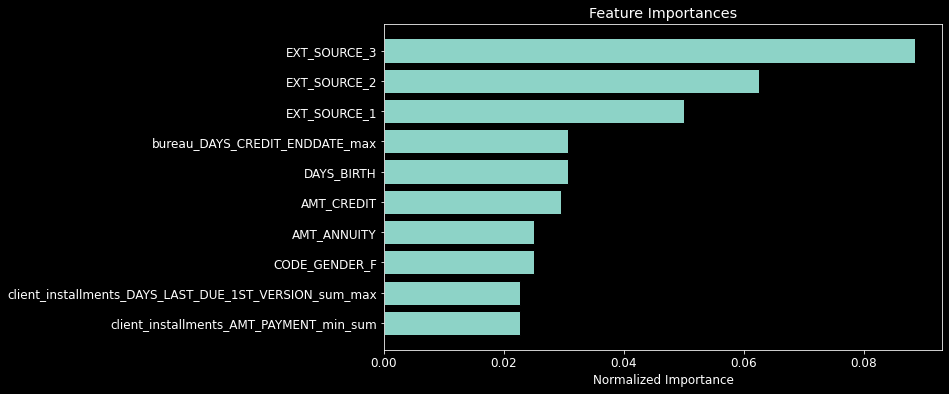

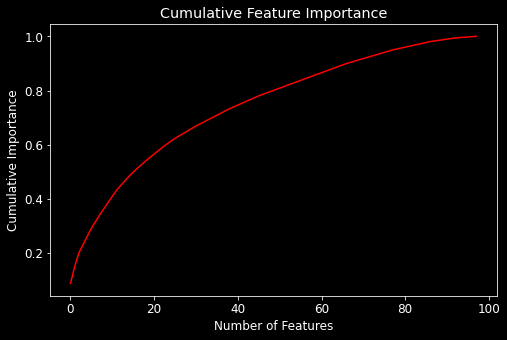

78 features required for 0.95 of cumulative importance.


In [15]:
# plotting features importance
fi_sorted = plot_feature_importances(feature_importances, threshold=0.95, nb_feat=10)

The process was harsh. About 80% of the features have been dropped. Most of the main features remain the same (7 over 10). The relative importance of the first three is however more important than what had been observed previously and is much more contrasted compared to the following ones (we can also notice the change in their order of importance, previously EXT_SOURCE_1, 2 and 3, now EXT_SOURCE_3, 2 and 1. )

In [16]:
start_time = timeit.default_timer()

# Training and testing of the model
metrics = run_experiment(lgbm_model, train, n_folds = 5)

time_elapsed = round((timeit.default_timer() - start_time)/60,2)
print('Total computing time: %0.2f minutes' % time_elapsed)

Total computing time: 0.37 minutes


In [17]:
print(metrics.iloc[5][1:3])
print('\ntrain-valid gap:',round(metrics.iloc[5][1]-metrics.iloc[5][2],6))

train    0.767932
valid    0.762272
Name: 5, dtype: object

train-valid gap: 0.00566


This last features removal had a slight impact on the ROC AUC scores and on the gap value. While the ROC AUC scores are both slightly reduced, the gap between them is slightly increased. However, the computation time is also greatly reduced (which is a really good surprise since it was the weakness of the model).

#### Training

For the pruposes of the application we have to compute a scaler, an imputer and a model separately. To do so we do again a training, fitting and predictions. As the training base has been profoundly modified with the last reduction of features it is necessary to align the test base there so that the model can run efficiently.

In [18]:
# Save the TARGET (will be lost in aligning process)
labels = train['TARGET']

In [19]:
# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (307511, 99)
test shape:  (48744, 99)


In [20]:
# Restore of the TARGET values
train['TARGET'] = labels

Now we can perform the last training, fitting, predictions run.

In [21]:
# Extract the ids
train_ids = train['SK_ID_CURR']

In [22]:
# Remove the ids and target (unwanted column)
features = train.drop(columns = ['SK_ID_CURR', 'TARGET'])

In [23]:
# Extract feature names
feature_names = list(features.columns)

In [24]:
# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Transform training data
features = imputer.fit_transform(features)

In [25]:
# Scale the features
scaler = MinMaxScaler(feature_range = (0, 1))
    
# Transform training data
features = scaler.fit_transform(features)

In [26]:
# Light Gradient Boosting Machine (optimized parameters)
lgbm_model = lgbm.LGBMClassifier(boosting_type='goss', objective='binary',num_leaves=5,
                                 n_estimators=82, learning_rate=0.092, reg_alpha=0.82,
                                 reg_lambda=0.4, subsample=1.0, colsample_bytree=0.55,
                                 is_unbalance=False, random_state=0)

In [27]:
# Training of the model
lgbm_model.fit(features, labels)

LGBMClassifier(boosting_type='goss', colsample_bytree=0.55, is_unbalance=False,
               learning_rate=0.092, n_estimators=82, num_leaves=5,
               objective='binary', random_state=0, reg_alpha=0.82,
               reg_lambda=0.4)

In [28]:
# make predictions for all train data (for incomming verification)
train_pred=lgbm_model.predict_proba(features)

In [29]:
# for information
train_pred[0:10,1]

array([0.76907207, 0.30245132, 0.26517663, 0.51476314, 0.58254439,
       0.33637843, 0.08225137, 0.13485795, 0.44952007, 0.40956851])

In [30]:
# save imputer, scaler and model to file
pickle.dump(imputer, open('imputer.pickle.dat', 'wb'))
pickle.dump(scaler, open('scaler.pickle.dat', 'wb'))
pickle.dump(lgbm_model, open('payback_predictor.pickle.dat', 'wb'))

At this stage we have a model capable of making payback failure probability predictions. In order to test the model we are going to load it and test it with the test dataset as if the informations were unknown. Since the test data are untouched it's necessary to apply the same traitements as performed on the training base (imputation of missing value and normalization).

In [31]:
# load model, imputer and scaler from file
loaded_model = pickle.load(open('payback_predictor.pickle.dat', 'rb'))
loaded_imputer = pickle.load(open('imputer.pickle.dat', 'rb'))
loaded_scaler = pickle.load(open('scaler.pickle.dat', 'rb'))

In [32]:
# Extract the ids of test dataset
test_ids = test['SK_ID_CURR']

In [33]:
# Remove the ids
test_features = test.drop(columns = ['SK_ID_CURR'])

In [34]:
# Imput missing values
test_features = loaded_imputer.transform(test_features)

In [35]:
# Normalization
test_features = loaded_scaler.transform(test_features)

In [36]:
# make predictions for all test data
payback_pred = loaded_model.predict_proba(test_features)

In [37]:
# Make the submission dataframe
submission_load = pd.DataFrame({'SK_ID_CURR': test_ids, 'PREDICTION': payback_pred[:,1]})

In [38]:
submission_load.head()

,SK_ID_CURR,PREDICTION
0,100001,0.367210
1,100005,0.659771
2,100013,0.151730
3,100028,0.240472
4,100038,0.724099


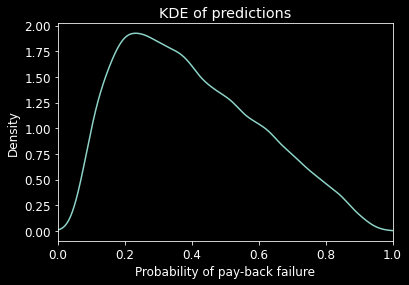

In [39]:
submission_load['PREDICTION'].plot.kde(bw_method='scott').set_xlim(0, 1)
plt.xlabel('Probability of pay-back failure')
plt.title('KDE of predictions')
plt.show()

In [40]:
# Creation of a general dataframe (ids, predictions and input data)
test_general_df = submission_load
test_general_df = test_general_df.join([pd.DataFrame(data=test_features[:,i], columns=[feature_names[i]])
                   for i in range(test_features.shape[1])])

In [41]:
test_general_df.head()

,SK_ID_CURR,PREDICTION,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,client_installments_RATE_DOWN_PAYMENT_sum_max,client_installments_RATE_DOWN_PAYMENT_sum_sum,client_installments_NAME_YIELD_GROUP_high_sum_mean,client_installments_NAME_SELLER_INDUSTRY_Connectivity_sum_mean,client_installments_DAYS_TERMINATION_count_mean,client_installments_CNT_PAYMENT_mean_mean,client_installments_CNT_PAYMENT_sum_max,client_installments_HOUR_APPR_PROCESS_START_mean_mean,client_installments_HOUR_APPR_PROCESS_START_mean_max,client_installments_AMT_DOWN_PAYMENT_sum_sum
0,100001,0.367210,0.242273,0.244190,0.232468,0.257000,0.337542,0.762177,0.756694,0.887175,...,0.316912,0.030606,1.00,1.00,1.00,0.133333,0.133333,0.565217,0.565217,0.007592
1,100005,0.659771,0.162512,0.082874,0.193319,0.491595,0.403890,0.543654,0.570897,0.774489,...,0.331000,0.031967,0.50,0.50,0.50,0.200000,0.200000,0.456522,0.478261,0.013448
2,100013,0.151730,0.391825,0.288228,0.836389,0.260475,0.292616,0.544777,0.897642,0.513269,...,0.408369,0.039438,0.25,0.25,0.75,0.288889,0.600000,0.630435,0.782609,0.020334
3,100028,0.240472,0.641077,0.713270,0.581668,0.361433,0.634329,0.809456,0.905878,0.415312,...,0.525900,0.050787,0.00,0.20,0.40,0.188889,0.400000,0.469565,0.565217,0.033890
4,100038,0.724099,0.341974,0.270623,0.373661,0.134897,0.687091,0.776269,0.811756,0.407809,...,0.265962,0.025686,0.50,0.50,0.50,0.400000,0.600000,0.239130,0.304348,0.024387


#### Try of unique prediction from a single row of the test dataset

The test dataset, except during the aligning process, has remained untouched. All the transformations has been done localy on a copy (test_features). Here we test the model capacity to make a prediction on a single row (as if it was given like a new client).

In [42]:
# Extract of a single row (arbitrary choice)
row = test[test['SK_ID_CURR']==100005]

In [43]:
# Drop unwanted column
row.drop(columns='SK_ID_CURR', inplace=True)

In [44]:
# Impute missing value and normalize
row = imputer.transform(row)
row = scaler.transform(row)

In [45]:
# Perform prediction
row_pred = loaded_model.predict_proba(row)[0,1]
round(row_pred,6)

0.659771

The prediction is exactly the same. We can write a function doing all the steps at once.

In [46]:
def prediction(model, imputer, scaler, dataset, client_id):
    
    # Extract of a single row
    row = dataset[dataset['SK_ID_CURR']==client_id]
    
    # Drop unwanted column
    if 'TARGET' in dataset.columns:
        row.drop(columns=['SK_ID_CURR','TARGET'], inplace=True)
    else:
        row.drop(columns=['SK_ID_CURR'], inplace=True)
    
    # Impute missing value and normalize
    row = imputer.transform(row)
    row = scaler.transform(row)
    
    # Perform prediction
    row_pred = model.predict_proba(row)[0,1]

    return row_pred

#### Few tests of the function on the training / test dataframe

In [47]:
round(prediction(loaded_model, loaded_imputer, loaded_scaler, test, 100001),6)

0.36721

In [48]:
round(prediction(loaded_model, loaded_imputer, loaded_scaler, train, 100002),6)

0.769072

This seems to work just as well with the training dataset as it does with the test dataset. We will be able to use this function confidently in the second part of the application (computation of predictions on a loaded dataset).

### Building of a global dataframe (app)

For the purposes of the application, we want to have access to the predictions of all the clients (i.e. the training database and the test database). So we build a global base containing the features of both on which we run the imputer, the scaler and the model.

In [49]:
global_df = train.append(test).sort_values(by='SK_ID_CURR').reset_index(drop=True)
global_df.shape

(356255, 100)

In [50]:
# Save of the ids
global_ids = global_df['SK_ID_CURR']

In [51]:
# Remove the ids and eventual TARGET values
global_features = global_df.drop(columns = ['SK_ID_CURR', 'TARGET'])

In [52]:
# Imput missing values
global_features = loaded_imputer.transform(global_features)

# Normalization
global_features = loaded_scaler.transform(global_features)

In [53]:
# make predictions for all global data
payback_pred = loaded_model.predict_proba(global_features)

In [54]:
# Make the submission dataframe
submission_load = pd.DataFrame({'SK_ID_CURR': global_ids, 'PREDICTION': payback_pred[:,1]})
submission_load.head()

,SK_ID_CURR,PREDICTION
0,100001,0.367210
1,100002,0.769072
2,100003,0.302451
3,100004,0.265177
4,100005,0.659771


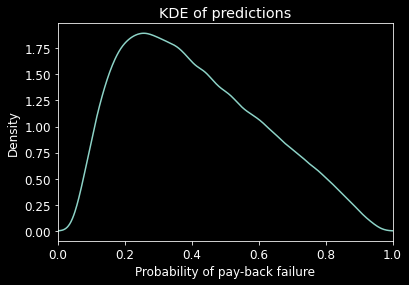

In [55]:
submission_load['PREDICTION'].plot.kde(bw_method='scott').set_xlim(0, 1)
plt.xlabel('Probability of pay-back failure')
plt.title('KDE of predictions')
plt.show()

In [56]:
# Merging of the global dataframe (features) with the global predictions
global_general_df = global_df.merge(submission_load, on='SK_ID_CURR')

In [57]:
# Reduction of the database to those used in the application (dashboard part)
global_general_extract=global_general_df[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH','AMT_CREDIT','PREDICTION','SK_ID_CURR']]
# Saving of the global_general_extract df in CSV files
global_general_extract.to_csv('global_general_extract.csv', index = False)

In [58]:
global_general_extract.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,PREDICTION,SK_ID_CURR
0,0.752615,0.789654,0.159520,-19241,568800.0,0.367210,100001
1,0.083037,0.262949,0.139376,-9461,406597.5,0.769072,100002
2,0.311267,0.622246,NaN,-16765,1293502.5,0.302451,100003
3,NaN,0.555912,0.729567,-19046,135000.0,0.265177,100004
4,0.564990,0.291656,0.432962,-18064,222768.0,0.659771,100005


### Building of a reduced database for KDE plots (app)

For the purposes of the application, we want to plot the kernel density estimators of few features selected among the most important (i.e. the five most important ones). Since it doesn't seem necessary to load all the featues for only few of them we make a reduction and keep only the ones usefull. We're going to need to separate clients based on their payback success / failure, so we will have to limit the selection to clients of the training base. 

In [59]:
# Reduced database for KDE plots in application
train_extract=train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH','AMT_CREDIT','TARGET','SK_ID_CURR']]
# Saving of the train_extract df in CSV files
train_extract.to_csv('train_extract.csv', index = False)

In [60]:
train_extract.head()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,TARGET,SK_ID_CURR
0,0.083037,0.262949,0.139376,-9461,406597.5,True,100002
1,0.311267,0.622246,NaN,-16765,1293502.5,False,100003
2,NaN,0.555912,0.729567,-19046,135000.0,False,100004
3,NaN,0.650442,NaN,-19005,312682.5,False,100006
4,NaN,0.322738,NaN,-19932,513000.0,False,100007


### Some extracts of the global dataframe (app)

For the purposes of the application, we want to test the possiblity of computing predictions on loaded datasets (with a loaded scaler, imputer and model). To give an idea of the results obtained in this aim we make some random extractions of the global dataframe (the one with all the features but no prediction).

In [61]:
# Extract a random sample of 10 clients
global_extract = global_df.sample(n=10, random_state=0)
# Saving of the extracted df in CSV file
global_extract.to_csv('global_extract_10.csv', index = False)

In [62]:
# Extract of global
global_extract2 = global_df.sample(n=100, random_state=0)
# Saving of the extracted df in CSV file
global_extract2.to_csv('global_extract_100.csv', index = False)

In [63]:
# Extract of global
global_extract3 = global_df.sample(n=1000, random_state=0)
# Saving of the extracted df in CSV file
global_extract3.to_csv('global_extract_1000.csv', index = False)